Hand classification using linear regression
===

In [1]:
# Imports
from IPython.display import Video
import numpy as np
from matplotlib import pyplot as plt
import cv2
import time
import queue
import statistics

## Preview video with frames
---

In [2]:
def preview_video(input_video_path: str, output_video_path: str):
    cap = cv2.VideoCapture(input_video_path)
    out = cv2.VideoWriter(output_video_path, -1, 20.0, (640,480))
    # get total number of frames
    totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

    suc, prev = cap.read()
    prevgray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
    out.write(prevgray-prevgray)

    for image in range(int(totalFrames) - 1):

        suc, img = cap.read()
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   
        
        fps = str(image) 
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        cv2.putText(gray, fps, (7, 70), font, 3, (100, 255, 0), 3, cv2.LINE_AA)
        
        gray_bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
        
        out.write(gray_bgr)

        
    cap.release()
    out.release()
    
    
preview_video('gmm_fingers.mp4','gmm_fingers_frames.mp4')
Video('gmm_fingers_frames.mp4')

## Save images as resized data
---

In [3]:
cap = cv2.VideoCapture('gmm_fingers.mp4')

# get total number of frames
totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

img_size = 128


suc, prev = cap.read()
prevgray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)

prevgray = cv2.resize(prevgray, (img_size,img_size))

images = np.zeros((np.shape(prevgray)[0]*np.shape(prevgray)[1],int(totalFrames)),np.uint8)

images[:,0] = prevgray.flatten()

for image in range(int(totalFrames) - 1):

    suc, img = cap.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    gray = cv2.resize(gray, (img_size,img_size))
    
    images[:,image] = gray.flatten()
    
    
cap.release()

In [4]:
def show_img_in_notebook(frame):
    RGB_im = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    
    plt.imshow(RGB_im)
    plt.title("Video")
    plt.show()
    
# show_img_in_notebook(images[:,:,100])

## Image Labeling
---

In [5]:
labels = np.zeros((int(totalFrames)),np.uint8)

labels[:] = 255
labels[:80] = 5
labels[100:145] = 4
labels[150:210] = 3
labels[220:280] = 2
labels[300:360] = 1
labels[370:420] = 0

## Remove unlabeled data
---

In [6]:
X_data = np.transpose(images)

Y_lables = np.reshape(labels, (int(totalFrames),1))

X_data = X_data[Y_lables[:, -1] != 255]

Y_lables = Y_lables[Y_lables[:, -1] != 255]



## Split data and labels to train and test sets
---

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_data, Y_lables, test_size=0.15, random_state=42)

## Fit model
---

In [8]:
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(x_train,y_train)

#
y_pred=logreg.predict(x_test)

g:\My Drive\Repositories\Home Repositories\IMP_AR_project\.venv\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Create confusion matrix
---

In [9]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[10,  0,  0,  0,  0,  0],
       [ 0,  7,  0,  0,  0,  0],
       [ 0,  0,  8,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0],
       [ 0,  0,  0,  0,  4,  0],
       [ 0,  0,  0,  0,  0, 15]], dtype=int64)

In [12]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

Text(0.5, 257.44, 'Predicted label')

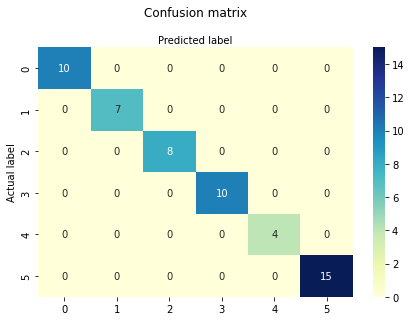

In [13]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## Saving and loading model
---

In [15]:
import pickle   # pip install pickle-mixin

# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(logreg, open(filename, 'wb'))

In [17]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_test, y_test)
print(result)



1.0


## Preview model on video
---

In [20]:
def preview_pred_video(input_video_path: str, output_video_path: str):
    cap = cv2.VideoCapture(input_video_path)
    out = cv2.VideoWriter(output_video_path, -1, 20.0, (640,480))
    # get total number of frames
    totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

    suc, prev = cap.read()
    prevgray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
    out.write(prevgray-prevgray)

    for image in range(int(totalFrames) - 1):

        suc, img = cap.read()
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   
        
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        gray_smaller = cv2.resize(gray, (img_size,img_size)).flatten()
        
        gray_smaller = np.reshape(gray_smaller,(1,img_size*img_size))
        
        y_pred=logreg.predict(gray_smaller)
        
        predict = str(y_pred)
        
        cv2.putText(gray, predict, (7, 70), font, 3, (100, 255, 0), 3, cv2.LINE_AA)
        
        gray_bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
        
        out.write(gray_bgr)

        
    cap.release()
    out.release()
    
    
preview_pred_video('gmm_fingers.mp4','gmm_fingers_pred.mp4')
Video('gmm_fingers_pred.mp4')